 # 1. Frame the problem

# 2. Select a performance measure

# 3. Check the assumptions

# 4. Get the Data

In [1]:
import os
import tarfile
import urllib

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("data", "01")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [3]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    """Creates `HOUSING_PATH`, Downloads & Extracts the contents of `HOUSING_URL` into `HOUSING_PATH`
    
    # Arguments:
        housing_url, string: the download link
        housing_path, string: where to download & extract data
    """
    os.makedirs(name=housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(url=housing_url, filename=tgz_path)
    housing_tgz = tarfile.open(name=tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
fetch_housing_data()

In [6]:
import pandas as pd

In [10]:
def load_housing_data(housing_path=HOUSING_PATH):
    """Loads Housing data into a pandas dataframe.
    
    # Arguments:
        housing_path: the path where `housing.csv` exists
    
    # Returns:
        data, pd.DataFrame: the housing data as a pandas dataframe
    """
    data_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(data_path)

In [11]:
housing = load_housing_data()

# 5. Simple check on Data

In [12]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [13]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [14]:
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [15]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


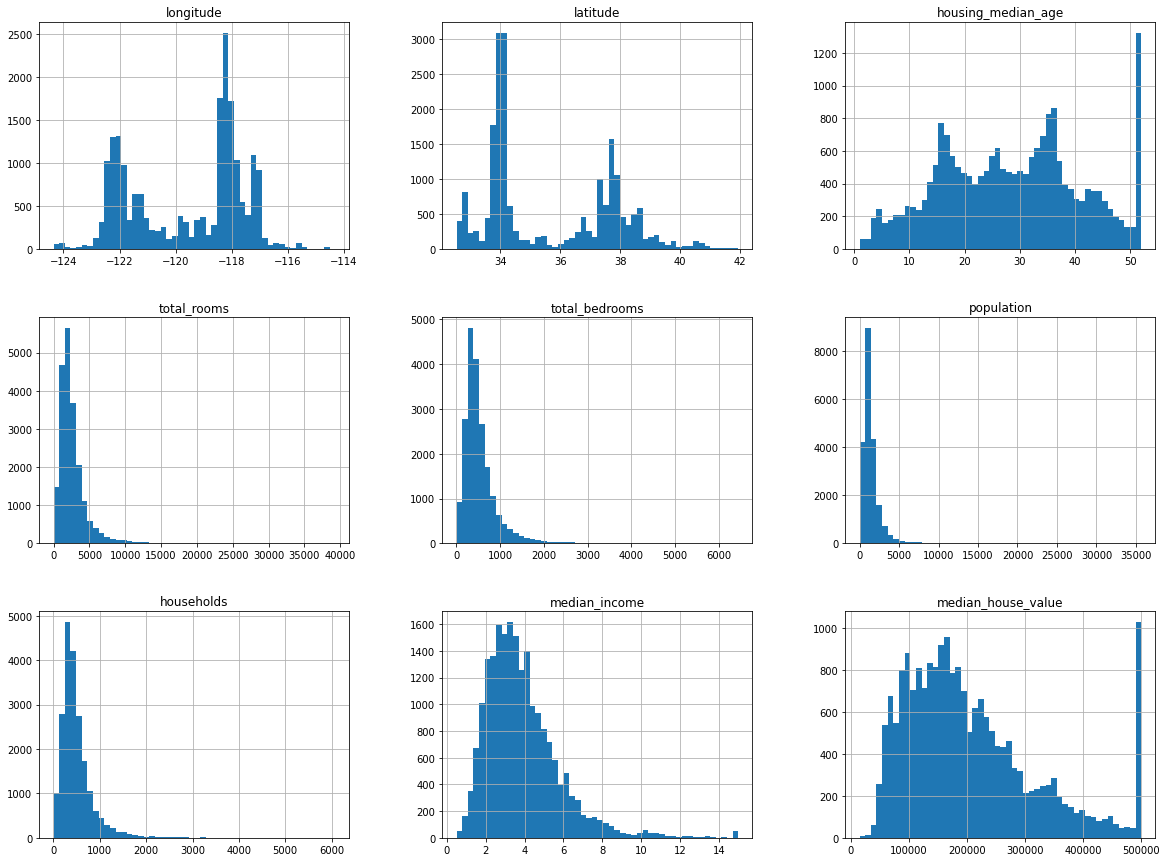

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

1. `median_income` is not expressed in USD but it is categorized and seemed to be capped
2. `housing_median_age` & `median_housing_value` variables are capped
3. All attributes have very different scales
4. many histograms are tail heav (== they extend much further to the right of the median than to the left)

# 6. Divide the data (Train/Test split)

In [33]:
import numpy as np

def split_train_test(data, test_ratio):
    np.random.seed(42)
    shuffled_indicies = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    train_indices = shuffled_indicies[test_set_size:]
    test_indices = shuffled_indicies[:test_set_size] # 0 ~ (test_set_size-1)
    return data.iloc[train_indices], data.iloc[test_indices]

In [34]:
train_set, test_set = split_train_test(housing, 0.2)

One way to make this method reproducible is to by putting seed before the randomization.

However, this also does not guarantee that the test set is the data that hasn't been touched.

In order to solve this problem, we can use Hash.

In [36]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2 * 32

In [37]:
def split_train_test_set_by_id(data, test_set_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_:test_set_check(id_, test_set_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [38]:
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_set_by_id(housing_with_id, 0.2, 'index')

In [39]:
# This also doesn't guarantee that the test set is stable, if the data is being removed
# & If the data is not appended at the bottom.
# Solution : use the most stable column as an identifier

In [40]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_Set = split_train_test_set_by_id(housing_with_id, 0.2, "id")

In [42]:
housing.loc[:5]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY


In [53]:
housing.iloc[:5] # it doesn't include 5

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
# When splitting the dataset, 
# 0~A A~n --> use iloc
# If it is dividing with a specific indices use loc 

In [63]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

<AxesSubplot:>

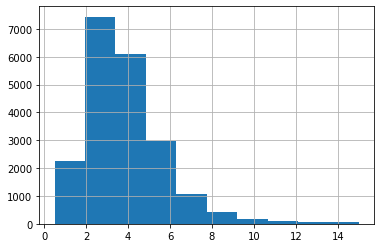

In [66]:
housing.median_income.hist()

If the median income is the most important variable to predict the median housing price, you should make sure to have a test set that represents the various categories of incomes in the whole dataset

In [44]:
housing = (
    housing
    .assign(income_category = pd.cut(
        housing.median_income,
        bins = [0, 1.5, 3.0, 4.5, 6, np.inf],
        labels=[1, 2, 3, 4, 5],
        )   
    )
)

<AxesSubplot:>

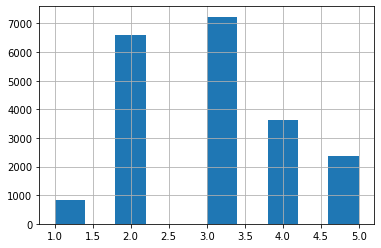

In [47]:
housing.income_category.hist()

In [48]:
from sklearn.model_selection import StratifiedShuffleSplit

In [51]:
# split(X, y, groups=None)[source] y array-like of shape (n_samples,) or (n_samples, n_labels)
# The target variable for supervised learning problems. Stratification is done based on the y labels.

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_category"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

<AxesSubplot:>

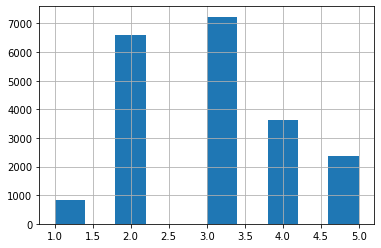

In [55]:
housing.income_category.hist()

<AxesSubplot:>

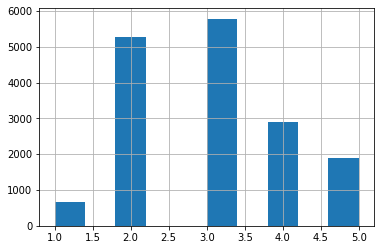

In [53]:
strat_train_set.income_category.hist()

<AxesSubplot:>

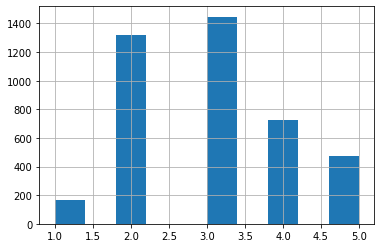

In [54]:
strat_test_set.income_category.hist()

In [62]:
housing.income_category.value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_category, dtype: float64

In [61]:
strat_train_set.income_category.value_counts() / len(strat_train_set)

3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: income_category, dtype: float64

In [58]:
strat_test_set.income_category.value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_category, dtype: float64

In [63]:
# drop the income category from the dataset
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_category", axis=1, inplace=True)

In [64]:
housing = strat_train_set.copy()

# 7. EDA

In [65]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN
...,...,...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900,268500.0,<1H OCEAN
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139,90400.0,INLAND
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797,140400.0,<1H OCEAN
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964,258100.0,<1H OCEAN


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

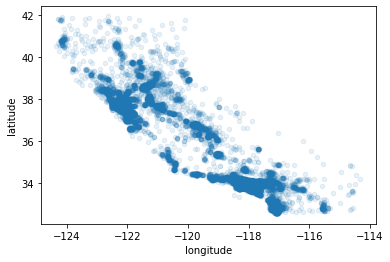

In [67]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

<function matplotlib.pyplot.legend(*args, **kwargs)>

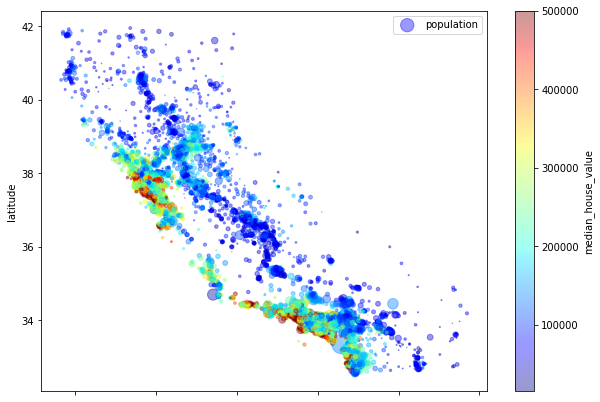

In [72]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, 
s=housing['population']/100, label='population', figsize=(10,7), 
c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend
# s : size of each point
# c: color of each point

In [73]:
corr_matrix = housing.corr()

In [75]:
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105823,0.048909,0.076686,0.108071,0.063146,-0.019615,-0.047466
latitude,-0.924478,1.000000,0.005737,-0.039245,-0.072550,-0.115290,-0.077765,-0.075146,-0.142673
housing_median_age,-0.105823,0.005737,1.000000,-0.364535,-0.325101,-0.298737,-0.306473,-0.111315,0.114146
total_rooms,0.048909,-0.039245,-0.364535,1.000000,0.929391,0.855103,0.918396,0.200133,0.135140
total_bedrooms,0.076686,-0.072550,-0.325101,0.929391,1.000000,0.876324,0.980167,-0.009643,0.047781
population,0.108071,-0.115290,-0.298737,0.855103,0.876324,1.000000,0.904639,0.002421,-0.026882
households,0.063146,-0.077765,-0.306473,0.918396,0.980167,0.904639,1.000000,0.010869,0.064590
median_income,-0.019615,-0.075146,-0.111315,0.200133,-0.009643,0.002421,0.010869,1.000000,0.687151
median_house_value,-0.047466,-0.142673,0.114146,0.135140,0.047781,-0.026882,0.064590,0.687151,1.000000


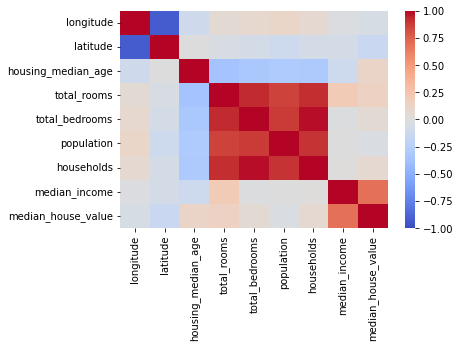

In [86]:
import seaborn as sns

ax = sns.heatmap(
    corr_matrix,
    vmin=-1, vmax=1, center=0,
    cmap=plt.get_cmap('coolwarm')
)

In [90]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

array([[<AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='total_rooms', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_income', yla

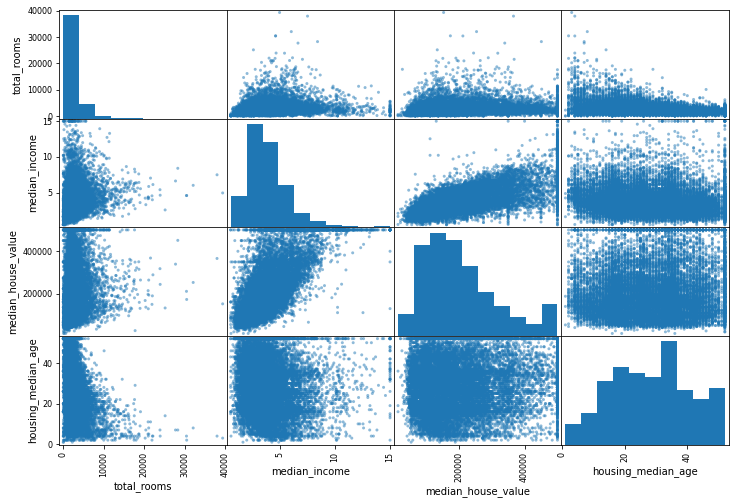

In [96]:
from pandas.plotting import scatter_matrix
attributes = ['total_rooms',
'median_income',
'median_house_value',
'housing_median_age']
scatter_matrix(housing[attributes], figsize=(12,8))


In [97]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN


In [100]:
housing = (
    housing
        .assign(
            rooms_per_household=housing.total_rooms/housing.households,
            bedrooms_per_room=housing.total_bedrooms/housing.total_rooms,
            population_per_household=housing.population/housing.households,
        )

)

In [101]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND,5.485836,0.205784,3.168555
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN,6.927083,0.160714,2.623698
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND,5.393333,0.191595,2.223333
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN,3.886128,0.276505,1.859213
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN,6.096552,0.182692,3.167241
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900,268500.0,<1H OCEAN,6.658342,0.184696,2.023976
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139,90400.0,INLAND,5.571932,0.179977,3.363188
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797,140400.0,<1H OCEAN,4.110465,0.234795,2.662791
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964,258100.0,<1H OCEAN,6.297405,0.183835,2.411178


In [102]:
corr_matrix = housing.corr()

In [104]:
corr_matrix.median_house_value.sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

# 8. Prepare data for the Models (ML algorithms)

In [106]:
# 1. divide the dataset into X,y
housing = strat_train_set.drop("median_house_value",axis=1)
housing_labels = strat_train_set["median_house_value"].copy()


In [ ]:
housing.dropna(subset=['total_bedrooms'])
housing.drop("total_bedrooms", axis=1)
housing['total_bedrooms'].fillna(median, inplace=True)

In [122]:
housing.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN
1481,-122.04,37.96,28.0,1207.0,252.0,724.0,252.0,3.6964,NEAR BAY
18125,-122.03,37.33,23.0,4221.0,671.0,1782.0,641.0,7.4863,<1H OCEAN
5830,-118.31,34.20,36.0,1692.0,263.0,778.0,278.0,5.0865,<1H OCEAN
17989,-121.95,37.27,17.0,1330.0,271.0,408.0,258.0,1.7171,<1H OCEAN
4861,-118.28,34.02,29.0,515.0,229.0,2690.0,217.0,0.4999,<1H OCEAN


In [123]:
# impute missing variables
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [125]:
housing_num = housing.drop("ocean_proximity", axis=1)

In [127]:
housing_num

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964
...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964


In [129]:
# calcaulating median for the whole dataframe 
# as we do not know for sure whether the data if it goes live has 
# na only for the total bedrooms or not
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [131]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [134]:
X = imputer.transform(housing_num)

In [136]:
# To transform the numpy stuff into a pandas dataframe
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [139]:
imputer.strategy

'median'

In [141]:
housing_tr.loc[housing.total_bedrooms.isna()]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580
...,...,...,...,...,...,...,...,...
1350,-121.95,38.03,5.0,5526.0,433.0,3207.0,1012.0,4.0767
4691,-118.37,34.07,50.0,2519.0,433.0,1117.0,516.0,4.3667
9149,-118.50,34.46,17.0,10267.0,433.0,4956.0,1483.0,5.5061
16757,-122.48,37.70,33.0,4492.0,433.0,3477.0,1537.0,3.0546


In [149]:
housing_cat = housing[['ocean_proximity']]

In [145]:
housing_cat.value_counts()

<1H OCEAN     7277
INLAND        5262
NEAR OCEAN    2124
NEAR BAY      1847
ISLAND           2
Name: ocean_proximity, dtype: int64

In [151]:
# One way of dealing with categorical variable: Ordinal Encoder
# This is easy to be implemented, however it implies that 
# the values cloes to each other are more similar compared to the ones where the values are far apart.
# Thus, when there is no ordinal relationship, it is better to use one hot encoding

from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded

array([[1.],
       [4.],
       [1.],
       ...,
       [0.],
       [0.],
       [1.]])

In [156]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [157]:
# If a category attribute has a large number of possible categories, then one-hot encoding will result in a large number of input features.
# Then it is better to replace the categorical input with useful numerical features

from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [159]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3,4,5,6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        rooms_per_hosehold = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_hosehold, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_hosehold, population_per_household]
    

In [194]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline(
    [
        ('imputer', SimpleImputer(strategy='median')),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ]
)

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [195]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

# 9. Select and Train a Model


In [196]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [200]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

In [201]:

print(f"predictions : {lin_reg.predict(some_data_prepared)}")
print(f"true values : {np.array(some_labels)}")

predictions : [ 86208. 304704. 153536. 185728. 244416.]
true values : [ 72100. 279600.  82700. 112500. 238300.]


In [206]:
# evaluating the model
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse
print(f"typical prediction error value is ${lin_rmse:.2f}")

typical prediction error value is $68633.41


In [209]:
# trying out more complex model (more powerful model)
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse


print(f"predictions : {tree_reg.predict(some_data_prepared)}")
print(f"true values : {np.array(some_labels)}")

predictions : [ 72100. 279600.  82700. 112500. 238300.]
true values : [ 72100. 279600.  82700. 112500. 238300.]


In [214]:
# k-fold cross validation

from sklearn.model_selection import cross_val_score
scores = cross_val_score(
    tree_reg, housing_prepared, housing_labels,
    scoring="neg_mean_squared_error", cv=10
    )
tree_rmse_scores = np.sqrt(-scores)

In [219]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean", scores.mean())
    print("Standard deviation:", scores.std())


In [222]:
display_scores(tree_rmse_scores)

Scores: [72842.1955669  72478.41288064 69687.41178582 71403.83810826
 69749.98033108 77609.5899644  69372.51006994 74264.59347258
 67369.00475452 71638.35155901]
Mean 71641.58884931411
Standard deviation: 2747.656120111871


In [225]:
lin_scores = cross_val_score(
    lin_reg, housing_prepared, housing_labels,
    scoring="neg_mean_squared_error", cv=10
)
lin_scores = np.sqrt(-lin_scores)
display_scores(lin_scores)

Scores: [71800.38078269 64114.99166359 67844.95431254 68635.19072082
 66801.98038821 72531.04505346 73992.85834976 68824.54092094
 66474.60750419 70143.79750458]
Mean 69116.4347200802
Standard deviation: 2880.6588594759014


In [227]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
forest_rmse = np.sqrt(mean_squared_error(housing_labels, forest_reg.predict(housing_prepared)))

In [228]:
forest_rmse

18670.48151276554

In [229]:
forest_scores = cross_val_score(
    forest_reg, housing_prepared, housing_labels,
    scoring="neg_mean_squared_error", cv=10
)
forest_scores = np.sqrt(-forest_scores)
display_scores(forest_scores)

Scores: [51205.99613843 48793.02156284 46691.61326218 51741.6428839
 47823.15161192 51807.14800387 52543.46686028 49803.06449127
 48403.31668796 53761.60363572]
Mean 50257.40251383756
Standard deviation: 2178.047874179106


In [230]:
import joblib
joblib.dump(forest_reg, "rf_model.pkl")
mymodel_loaded = joblib.load("rf_model.pkl")

['rf_model.pkl']

In [238]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(
    forest_reg, param_grid, cv=5,
    scoring='neg_mean_squared_error', return_train_score=True
)


In [239]:
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [240]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [243]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30)

In [244]:
cvres = grid_search.cv_results_

In [247]:
cvres.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_features', 'param_n_estimators', 'param_bootstrap', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

In [248]:
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

64017.630676829605 {'max_features': 2, 'n_estimators': 3}
55406.94177426873 {'max_features': 2, 'n_estimators': 10}
52788.799171176666 {'max_features': 2, 'n_estimators': 30}
60307.57188979447 {'max_features': 4, 'n_estimators': 3}
52760.203811549494 {'max_features': 4, 'n_estimators': 10}
50120.12206200225 {'max_features': 4, 'n_estimators': 30}
59657.11501537096 {'max_features': 6, 'n_estimators': 3}
51763.048109501084 {'max_features': 6, 'n_estimators': 10}
49978.08156577556 {'max_features': 6, 'n_estimators': 30}
58417.76685592208 {'max_features': 8, 'n_estimators': 3}
52197.39634361329 {'max_features': 8, 'n_estimators': 10}
49961.864710956506 {'max_features': 8, 'n_estimators': 30}
63022.999461275656 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54175.5322127255 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60205.485647996495 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52234.27831280438 {'bootstrap': False, 'max_features': 3, 'n_estimator

In [249]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.43006746e-02, 6.59232787e-02, 4.28279105e-02, 1.57004842e-02,
       1.45265837e-02, 1.49259852e-02, 1.38292519e-02, 3.33582048e-01,
       5.78700870e-02, 1.10850481e-01, 7.01723614e-02, 9.80056488e-03,
       1.68904258e-01, 1.02655521e-04, 2.77027825e-03, 3.91309724e-03])

In [253]:
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

In [266]:
attributes

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'rooms_per_hhold',
 'pop_per_hhold',
 'bedrooms_per_room',
 '<1H OCEAN',
 'INLAND',
 'ISLAND',
 'NEAR BAY',
 'NEAR OCEAN']

In [268]:
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3335820477338871, 'median_income'),
 (0.16890425849638827, 'INLAND'),
 (0.11085048082123898, 'pop_per_hhold'),
 (0.074300674558951, 'longitude'),
 (0.07017236137294192, 'bedrooms_per_room'),
 (0.06592327865134087, 'latitude'),
 (0.05787008697802143, 'rooms_per_hhold'),
 (0.042827910450741635, 'housing_median_age'),
 (0.015700484196982577, 'total_rooms'),
 (0.01492598521154271, 'population'),
 (0.014526583728639995, 'total_bedrooms'),
 (0.01382925190311316, 'households'),
 (0.009800564879963827, '<1H OCEAN'),
 (0.003913097241559396, 'NEAR OCEAN'),
 (0.0027702782539185673, 'NEAR BAY'),
 (0.00010265552076853379, 'ISLAND')]

In [271]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_prediction = final_model.predict(X_test_prepared)
rmse_final_prediction = np.sqrt(mean_squared_error(y_test, final_prediction))
print(rmse_final_prediction)

47813.0640577074


In [273]:
from scipy import stats

confidence = 0.95
squared_errors = (final_prediction - y_test)**2
np.sqrt(stats.t.interval(
    confidence, 
    len(squared_errors) -1, 
    loc=squared_errors.mean(), 
    scale=stats.sem(squared_errors)
    )
)

array([45806.69383342, 49738.56641706])